In [431]:
# Basic packages.
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
tf.config.run_functions_eagerly(True)

# Visualization packages.
import seaborn as sns
import matplotlib.pyplot as plt

# Necessary variables for file exploration.
DATA_DIR = 'data'
TRANSFORMED_DIR = 'transformed'
feature_file = 'transformed_features.csv'
response_file = 'transformed_responses.csv'

# Read in the data.
feature_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, feature_file))
response_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, response_file))
feature_df.shape, response_df.shape

# Convert date to str & set as index.
feature_df['DATE'] = pd.to_datetime(feature_df['DATE'])
feature_df.set_index('DATE', drop=True, inplace=True)
response_df['Date'] = pd.to_datetime(response_df['Date'])
response_df.set_index('Date', drop=True, inplace=True)

# Normalize data frame.
normalized_df = (feature_df - feature_df.mean()) / feature_df.std()

# Perform a train-test split. Looking at the above data, let's train on all data prior to end of year 2005.
# Test on all data from 2005 to end of year 2019
# Keep beginning of 2020 through 2021 seperate for analysis and comparisons with other methods.
dates = np.array(feature_df.index)
# Add 1 to include December as a part of the train.
training_ends = np.where(dates == pd.to_datetime("2009-12-01"))[0][0] + 1
test_ends = np.where(dates == pd.to_datetime("2019-12-01"))[0][0] + 1
X_train, X_test, X_analysis = normalized_df.iloc[:training_ends, :], normalized_df.iloc[training_ends:test_ends, :], normalized_df.iloc[test_ends:, :]
y_train, y_test, y_analysis = response_df['Commodities Market'].iloc[:training_ends], response_df['Commodities Market'].iloc[training_ends:test_ends], response_df['Commodities Market'].iloc[test_ends:]
X_train.shape, X_test.shape, X_analysis.shape

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def graphHistory(history, title):
    """
    Function for graphing the training and valiedation accuracy and loss
    ...
    :param history - history object from keras desired to plot.
    :param title - str that will be the title of the resulting plot.
    """
    # summarize history for accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    #axes[0].title('Model Accuracy ' + title)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Tr. Acc', 'Val. Acc'])

    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    #axes[1].title('Model Loss ' + title)
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Tr. Loss', 'Val. Loss'])
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Do the data transformations...
n_steps = 4
lstm_X_train, lstm_y_train = split_sequence(y_train.values, n_steps)
lstm_X_test, lstm_y_test = split_sequence(y_test.values, n_steps)
lstm_X_analysis, lstm_y_analysis = split_sequence(y_analysis.values, n_steps)
print(lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape)

(212, 4) (212,) (116, 4) (116,)


In [432]:
# Reshape from (samples, timesteps) to (samples, timesteps, rows, columns, features)
n_features = 1
n_seq = 2
n_steps = 2
lstm_X_train = lstm_X_train.reshape((lstm_X_train.shape[0], n_seq, 1, n_steps, n_features))
lstm_X_test = lstm_X_test.reshape((lstm_X_test.shape[0], n_seq, 1, n_steps, n_features))
lstm_X_analysis = lstm_X_analysis.reshape((lstm_X_analysis.shape[0], n_seq, 1, n_steps, n_features))
print(lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape)

(212, 2, 1, 2, 1) (212,) (116, 2, 1, 2, 1) (116,)


In [433]:
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(1,2), activation='relu', kernel_initializer='he_normal', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics='accuracy')
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_67 (ConvLSTM2D) (None, 1, 1, 32)          8576      
_________________________________________________________________
flatten_67 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 33        
Total params: 8,609
Trainable params: 8,609
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 17.0208 - accuracy: 0.0094

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 29ms/step - loss: 17.0208 - accuracy: 0.0094 - val_loss: 17.3130 - val_accuracy: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 0s 24ms/step - loss: 16.7225 - accuracy: 0.0094 - val_loss: 17.1473 - val_accuracy: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 27ms/step - loss: 16.4498 - accuracy: 0.0094 - val_loss: 16.9943 - val_accuracy: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 0s 29ms/step - loss: 16.1908 - accuracy: 0.0094 - val_loss: 16.8546 - val_accuracy: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 0s 22ms/step - loss: 15.9508 - accuracy: 0.0094 - val_loss: 16.7277 - val_accuracy: 0.0000e+00
Epoch 6/100
7/7 [==============================] - 0s 25ms/step - loss: 15.7257 - accuracy: 0.0094 - val_loss: 16.6126 - val_accuracy: 0.0000e+00
Epoch 7/100
7/7 [==============================] - 0s 21ms/step - loss: 15.5147 - accuracy: 0.0094 - val_loss: 16.5075 - val_accuracy: 0

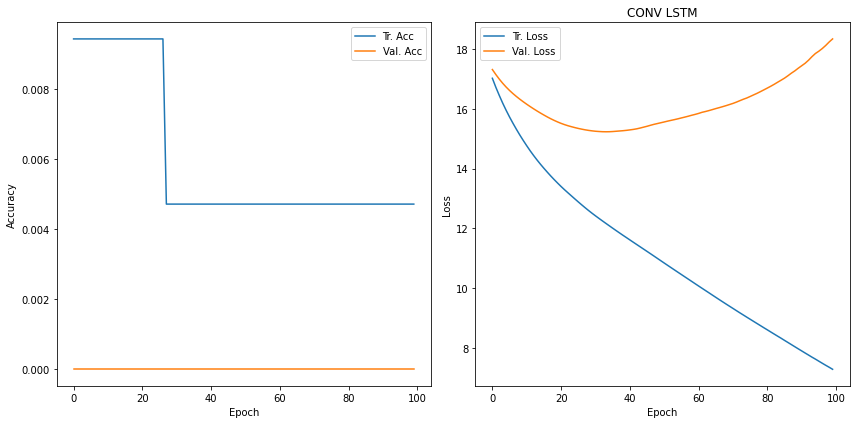

In [434]:

# Train and graph history...
history = model.fit(lstm_X_train, lstm_y_train, epochs=100, validation_data=(lstm_X_test, lstm_y_test), shuffle=False)
graphHistory(history, 'CONV LSTM')

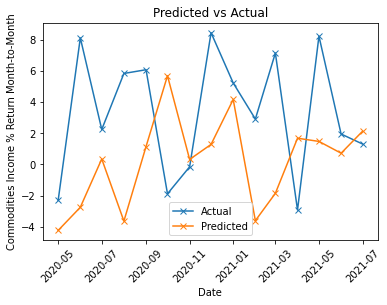

In [435]:
# Predict using the analysis data.
preds = model.predict(lstm_X_analysis)
np.linalg.norm(preds - lstm_y_analysis.reshape(preds.shape[0], 1))

# Plot all test data and then validation data and prediction data...
dates_test, dates_y_test = split_sequence(dates[training_ends: test_ends], 4)
dates_val, dates_y_val = split_sequence(dates[test_ends:], 4)
dates_test.shape, dates_val.shape, dates_y_test.shape, dates_y_val.shape
actual_dates = np.hstack((dates_y_test, dates_y_val))
pred_vals = preds.reshape(preds.shape[0], )
pred_dates = dates_y_val
plt.plot(pred_dates, lstm_y_analysis, label='Actual', marker='x')
plt.plot(pred_dates, pred_vals, label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Commodities Income % Return Month-to-Month')
plt.title('Predicted vs Actual')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [436]:
np.linalg.norm(np.nan_to_num(preds.reshape((preds.shape[0],)) - lstm_y_analysis, nan=0.456))

23.250802306266277

In [437]:
# define a fx. to split a multivariate sequence into samples
def split_sequences_mv(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [438]:
# Concat the X_train and y_train
dataset = np.hstack((X_train.values, y_train.values.reshape((y_train.shape[0], 1))))
test_data = np.hstack((X_test.values, y_test.values.reshape((y_test.shape[0], 1))))
analysis_data = np.hstack((X_analysis.values, y_analysis.values.reshape((y_analysis.shape[0], 1))))
X_train.shape, y_train.shape, dataset.shape, type(dataset)

# Do the data transformations...
n_steps = 4
lstm_X_train, lstm_y_train = split_sequences_mv(dataset, n_steps)
lstm_X_test, lstm_y_test = split_sequences_mv(test_data, n_steps)
lstm_X_analysis, lstm_y_analysis = split_sequences_mv(analysis_data, n_steps)
print(lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape)

# Reshape from (samples, timesteps) to (samples, subsequnces, timesteps, features)
n_features = 58
n_seq = 2
n_steps = 2
lstm_X_train = lstm_X_train.reshape((lstm_X_train.shape[0], n_seq, 1, n_steps, n_features))
lstm_X_test = lstm_X_test.reshape((lstm_X_test.shape[0], n_seq, 1, n_steps, n_features))
lstm_X_analysis = lstm_X_analysis.reshape((lstm_X_analysis.shape[0], n_seq, 1, n_steps, n_features))
print(lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape)

(213, 4, 58) (213,) (117, 4, 58) (117,)
(213, 2, 1, 2, 58) (213,) (117, 2, 1, 2, 58) (117,)


In [439]:
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.ConvLSTM2D(filters=18, kernel_size=(1,2), activation='relu', kernel_initializer='he_normal', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics='accuracy')
tf.keras.utils.plot_model(model, to_file='conv-lstm-multi.png', show_shapes=True)
model.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_68 (ConvLSTM2D) (None, 1, 1, 18)          11016     
_________________________________________________________________
dropout_64 (Dropout)         (None, 1, 1, 18)          0         
_________________________________________________________________
flatten_68 (Flatten)         (None, 18)                0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 19        
Total params: 11,035
Trainable params: 11,035
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
4/7 [================>.............] - ETA: 0s - loss: 7.5697 - accuracy: 0.0156

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 28ms/step - loss: 14.4512 - accuracy: 0.0141 - val_loss: 14.1983 - val_accuracy: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 0s 26ms/step - loss: 14.6855 - accuracy: 0.0094 - val_loss: 14.0064 - val_accuracy: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 24ms/step - loss: 13.9707 - accuracy: 0.0094 - val_loss: 13.8844 - val_accuracy: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 14.3791 - accuracy: 0.0141 - val_loss: 13.7639 - val_accuracy: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 0s 26ms/step - loss: 14.1007 - accuracy: 0.0141 - val_loss: 13.6716 - val_accuracy: 0.0000e+00
Epoch 6/100
7/7 [==============================] - 0s 25ms/step - loss: 13.2815 - accuracy: 0.0141 - val_loss: 13.5988 - val_accuracy: 0.0000e+00
Epoch 7/100
7/7 [==============================] - 0s 26ms/step - loss: 13.3329 - accuracy: 0.0094 - val_loss: 13.5417 - val_accuracy: 0

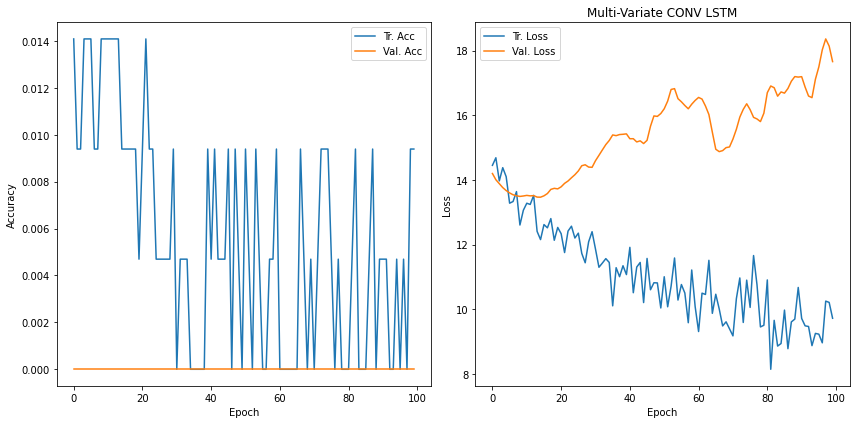

In [440]:

# Train and graph history...
history = model.fit(lstm_X_train, lstm_y_train, epochs=100, validation_data=(lstm_X_test, lstm_y_test), shuffle=False)
graphHistory(history, 'Multi-Variate CONV LSTM')

nan


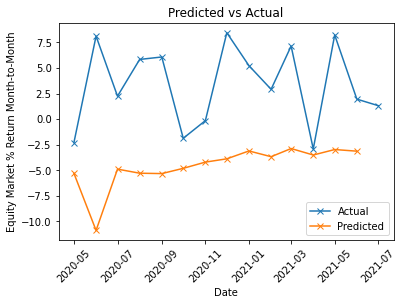

In [441]:
actual_dates = np.hstack((dates_y_test, dates_y_val))
preds = model.predict(lstm_X_analysis)
print(np.linalg.norm(preds - lstm_y_analysis.reshape(preds.shape[0], 1)))
pred_vals = preds.reshape(preds.shape[0], )
pred_dates = dates_y_val
plt.plot(pred_dates, lstm_y_analysis[1:], label='Actual', marker='x')
plt.plot(pred_dates, pred_vals[1:], label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Equity Market % Return Month-to-Month')
plt.title('Predicted vs Actual')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [442]:
np.linalg.norm(np.nan_to_num(preds.reshape((preds.shape[0],)) - lstm_y_analysis, nan=0.456))

34.88600375326747

In [443]:
uv_co = [28.3, 25.94, 26.11, 21.06, 26.43, 23.77, 30.44, 26.74, 22.21]
mv_co = [22.77, 28.06, 24.45, 24.23, 21.93, 30.18, 30.49, 22.18, 25.2]
len(uv_co), len(mv_co)

(9, 9)

In [310]:
uv_fi = [4.09, 4.16, 4.39, 4.52, 4.44, 4.63, 4.75, 4.23, 4.39, 4.33]
mv_fi = [3.79, 6.79, 9.52, 5.07, 4.06, 5.04, 4.49, 3.93, 15.37, 14.42]

In [311]:
uv_equities = [22.63, 18.74, 24.15,19.72, 17.09, 25.26, 21.72, 18.72, 23.90, 19.38]
mv_equities = [25.78, 20.77, 21.14, 24.16, 22.89, 23.18, 24.69, 24.29, 24.50, 22.39] 

In [446]:
from scipy import stats
stats.ttest_ind(uv_co, mv_co)

Ttest_indResult(statistic=0.11402858157707499, pvalue=0.9106337534455935)

In [315]:
len(uv_fi), len(mv_fi)

(10, 10)

In [444]:
np.mean(uv_co), np.mean(mv_co)

(25.666666666666668, 25.498888888888885)

In [445]:
np.std(uv_co), np.std(mv_co)

(2.758671177698906, 3.1159391109599484)